In [1]:
import mlflow
import ipywidgets as widgets
from IPython.display import display
import io
import os
import json
from PIL import Image
import numpy as np
import pandas as pd
import requests

In [2]:
# Define local host and endpoint url
def get_model_output(image):
    host = "127.0.0.1"
    url = f"http://{host}:5001/invocations"

    # Create configuration DataFrame
    predict_conf = pd.DataFrame(
        [
            {
                "image": np.array(image).tolist()
            }
        ]
    )

    # Create dictionary with pandas DataFrame in the split orientation
    json_data = {"dataframe_split": predict_conf.to_dict(orient="split")}

    # Score model
    response = requests.post(url, json=json_data)
    print("got response!!!!!")
    
    return Image.fromarray(np.uint8(response.json()["predictions"]))


got response!!!!!


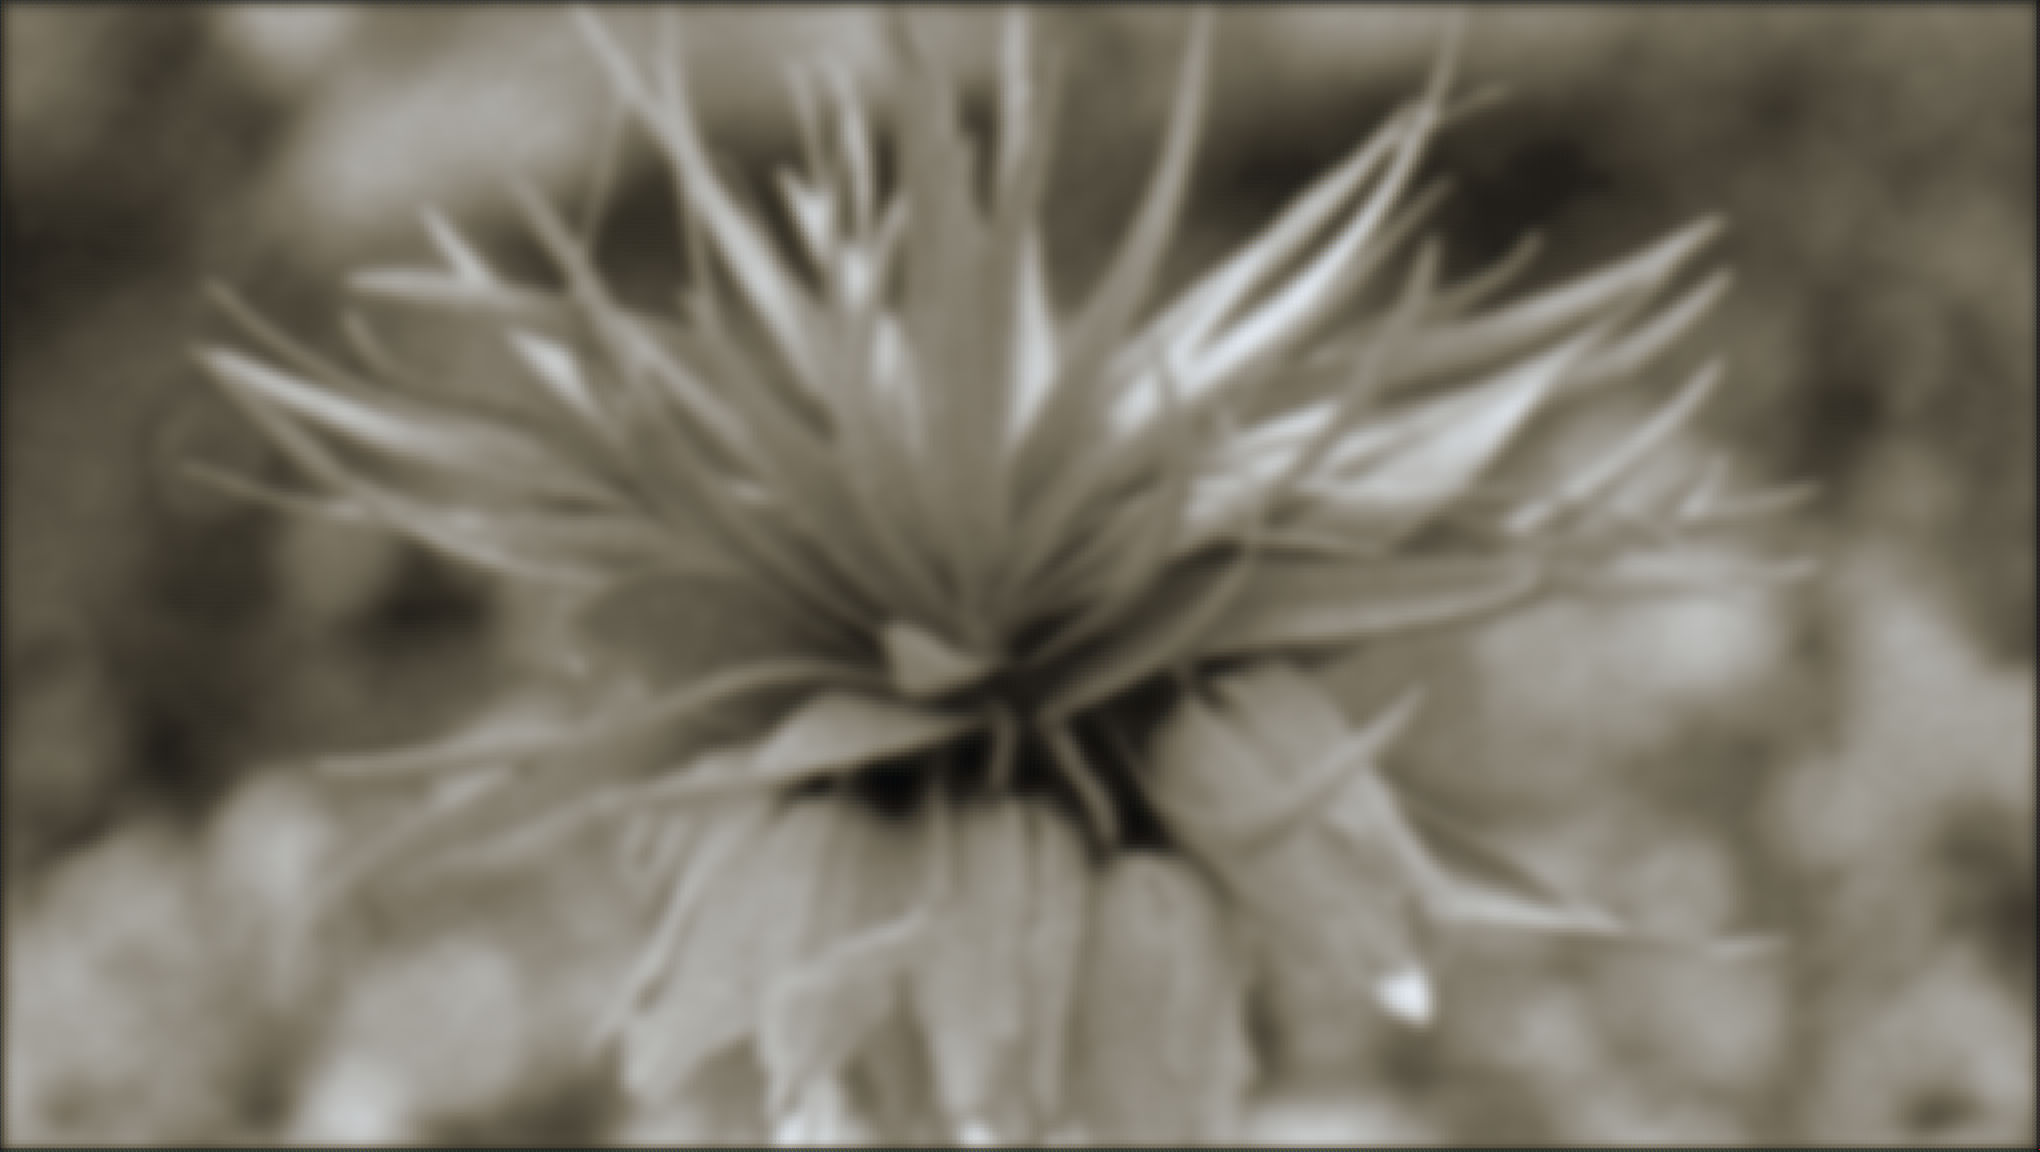

In [3]:
get_model_output(Image.open("test.png"))


In [4]:
class ImageVisualizer(object):
    # Class that shows three images, side by side horizontally, or vertically
    # The images are specified by a function that receives an index and returns a tuple with 3 PIL images
    def __init__(self, width, height, is_horizontal = True, image_getter = None, number_of_images = 0):
        self.img_index = 0
        self.width = width
        self.height = height
        self.is_horizontal = is_horizontal
        self.images = []
        if image_getter == None:
            self.image_getter = self.default_image_getter
        else:
            self.image_getter = image_getter
        self.number_of_images = number_of_images
        self.output = widgets.Output()
        self.image_widgets = None
        self.image_box = None
        self.main_box = None
        self.create_button_box()
        self.load_display()
        
    
    def default_image_getter(self, index):
        return(Image.new("RGB", (self.width, self.height)), 
               Image.new("RGB", (self.width, self.height)),
               Image.new("RGB", (self.width, self.height)))
    
    def previous_button_click(self, button):
        if self.img_index > 0:
            self.img_index = self.img_index - 1
            self.current_button.description = str(self.img_index)
            self.load_display()    

    def next_button_click(self, button):
        if self.img_index < self.number_of_images - 1:
            self.img_index = self.img_index + 1
            self.current_button.description = str(self.img_index)
            self.load_display()
            
    def create_button_box(self):
        self.previous_button = widgets.Button(
            description='Previous',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Previous Image',
        )
        
        self.current_button = widgets.Button(
            description='0',
            disabled=True,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Current image',
        )

        self.next_button = widgets.Button(
            description='Next',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Next Image',
        )
        self.previous_button.on_click(self.previous_button_click)
        self.next_button.on_click(self.next_button_click)
        self.button_box = widgets.HBox([self.previous_button, self.current_button, self.next_button])
    
    def load_display(self):
        self.images = self.image_getter(self.img_index)
        if self.image_widgets is None:
            self.image_widgets = [None] * len(self.images)
        
        for index in range(0, len(self.images)):
            byte_array = io.BytesIO()
            self.images[index].save(byte_array, format='PNG')
            if self.image_widgets[index] is None:
                self.image_widgets[index] = widgets.Image(
                    value = byte_array.getvalue(),
                    format = 'PNG',
                    width = self.width,
                    height = self.height,
                )
            else:
                self.image_widgets[index].value = byte_array.getvalue()

        if self.image_box is None:
            if self.is_horizontal:
                self.image_box = widgets.HBox(self.image_widgets)
            else:
                self.image_box = widgets.VBox(self.image_widgets)
            self.main_box = widgets.VBox([self.button_box, self.image_box])
            display(self.main_box, self.output)
        



In [5]:
HR_WIDTH = 2040
HR_HEIGHT = 1152
LR_WIDTH = 510
LR_HEIGHT = 288

def center_crop(img, new_width, new_height):
    width, height = img.size
    if width < height:
        img = img.rotate(90)     
    width, height = img.size
    if new_width > width:
        img = img.resize((new_width, height))
    if new_height > height:
        img = img.resize((width, new_height))
    width, height = img.size        
    new_left = (width - new_width) / 2
    new_top = (height - new_height) / 2
    return img.crop((new_left, new_top, new_left + new_width, new_top + new_height))

def load_images(index):
    lr_folder = "datafabric/DIV2K/DIV2K_train_LR_mild/"
    hr_folder = "datafabric/DIV2K/DIV2K_train_HR/"
    lr_suffix = "x4m"
    hr_list = os.listdir(hr_folder)
    hr_name, hr_ext = os.path.splitext(hr_list[index])
    lr_name =  f"{hr_name}{lr_suffix}{hr_ext}"
    hr_image = Image.open(os.path.join(hr_folder, hr_list[index]))
    lr_image = Image.open(os.path.join(lr_folder, lr_name))    
    out_image = get_model_output(lr_image)
    print(out_image)
    
    return (
        center_crop(lr_image, LR_WIDTH, LR_HEIGHT),
        center_crop(hr_image, HR_WIDTH, HR_HEIGHT),
        out_image
    )

ImageVisualizer(HR_WIDTH / 2, HR_HEIGHT / 2, is_horizontal = False, image_getter = load_images, number_of_images = 10)

got response!!!!!
<PIL.Image.Image image mode=RGB size=2040x1152 at 0x7F4E18446BD0>


Output()